[]

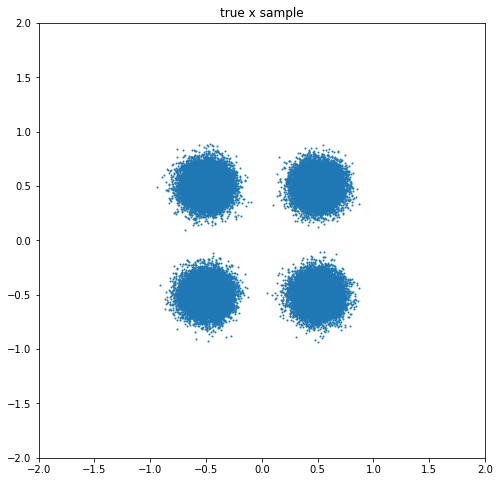

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_data):

        self.n_data = n_data
        _data = np.random.randn(n_data, 2)

        count = 0
        while count < n_data:
            for i in range(2):
                for j in range(2):
                    if count >= n_data:
                        break
                    _data[count][0] = 0.1 * _data[count][0] + (i % 2) - 0.5
                    _data[count][1] = 0.1 * _data[count][1] + (j % 2) - 0.5
                    count += 1
        self.data = torch.from_numpy(_data).float()

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        return self.data[idx]



dataset = CustomDataSet(80000)
sample_data = dataset.data.numpy()
plt.figure(figsize=(8, 8))
plt.title('true x sample')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.scatter(sample_data[:, 0], sample_data[:, 1], s=1)
plt.plot()

In [10]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=1, bias=True)
        )

    def forward(self, x):
        return self.layer(x)


class Generator(nn.Module):

    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.z_dim, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=2, bias=True),
        )

    def forward(self, x):
        return self.layer(x)

In [11]:
D = Discriminator()
G = Generator(z_dim=4)
D_solver = torch.optim.Adam(D.parameters(), lr=1e-4)
G_solver = torch.optim.Adam(G.parameters(), lr=1e-4)
mb_size = 64
loader = DataLoader(dataset, batch_size=mb_size, shuffle=True, drop_last=True)


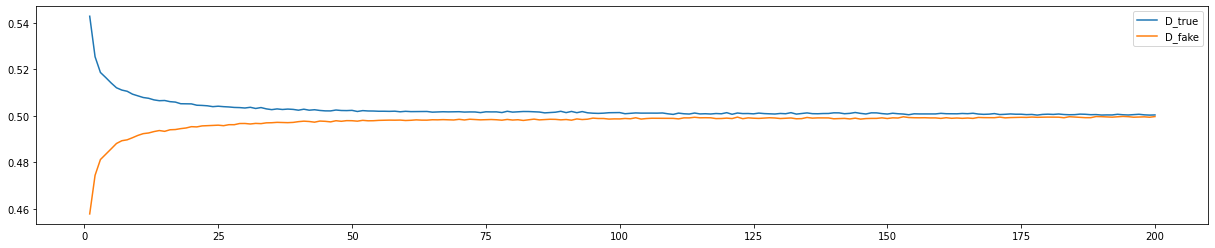

In [14]:
D_TRUE_AVG = []
D_FAKE_AVG = []
num_epochs = 200
a = 0.0
b = 1.0

for epoch in range(num_epochs):
    D_true_avg = 0.0
    D_fake_avg = 0.0
    for _, X in enumerate(loader):
        D_solver.zero_grad()
        D_true = D(X)
        D_fake = D(G(torch.randn(mb_size, G.z_dim)))
        D_true_loss = (D_true - b)**2
        D_fake_loss = (D_fake - a)**2
        D_loss = (D_true_loss + D_fake_loss).mean()
        D_loss.backward()
        D_solver.step()

        G_solver.zero_grad()
        X_fake = G(torch.randn(mb_size, G.z_dim))
        G_loss = ((D(X_fake) - b)**2).mean()
        G_loss.backward()
        G_solver.step()

        D_true_avg += D_true.mean().detach().item()
        D_fake_avg += D_fake.mean().detach().item()

    D_true_avg = D_true_avg / len(loader)
    D_fake_avg = D_fake_avg / len(loader)
    D_TRUE_AVG.append(D_true_avg)
    D_FAKE_AVG.append(D_fake_avg)
plt.figure(figsize=(21, 4))
plt.plot(np.arange(1, len(D_TRUE_AVG) + 1), D_TRUE_AVG, label='D_true')
plt.plot(np.arange(1, len(D_FAKE_AVG) + 1), D_FAKE_AVG, label='D_fake')
plt.legend()
plt.show()

[]

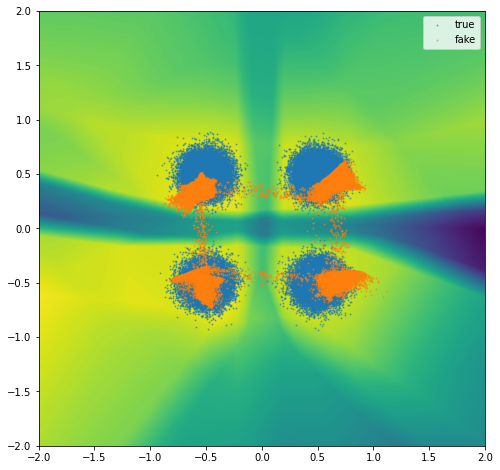

In [15]:
x1 = np.arange(-2.1, 2.1, 0.01)
x2 = np.arange(-2.1, 2.1, 0.01)
x1, x2 = np.meshgrid(x1, x2)
X = torch.from_numpy(np.stack((x1.reshape(-1), x2.reshape(-1)), axis=1)).float()
Dx = D(X).detach().numpy().reshape(x1.shape)
X_fake = G(torch.randn(80000, G.z_dim))
X_fake = X_fake.data.numpy()
plt.figure(figsize=(8, 8))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.contourf(x1, x2, Dx, 200)
plt.scatter(sample_data[:, 0], sample_data[:, 1], s=1, alpha=0.5, label='true')
plt.scatter(X_fake[:, 0], X_fake[:, 1], s=1, alpha=0.5, label='fake')
plt.legend()
plt.plot()